In [1]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0.4636,
    0.6048,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    optimizer = Optimizer()
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(verbose=False)
    print("sample size:", len(df))
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    print(f"RMSE(bins): {metrics['rmse']:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        deviation = abs(param - trained_param)
        deviations.append(deviation)
        print(f"{param} -> {trained_param}: deviation={deviation:.4f}")
    print(f"mean deviation: {np.mean(deviations):.4f}")

  0%|          | 0/273 [00:00<?, ?it/s]

sample size: 273
loss before: 0.3180, loss after: 0.2817


/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


RMSE(bins): 0.0504
1.1596 -> 2.1049: deviation=0.9453
1.7974 -> 2.6016: deviation=0.8042
13.1205 -> 3.6826: deviation=9.4379
49.3729 -> 4.5056: deviation=44.8673
7.2303 -> 7.3108: deviation=0.0805
0.5081 -> 0.5165: deviation=0.0084
1.5371 -> 1.3401: deviation=0.1970
0.001 -> 0.1249: deviation=0.1239
1.5052 -> 1.4316: deviation=0.0736
0.1261 -> 0.2388: deviation=0.1127
0.9735 -> 0.9051: deviation=0.0684
1.8924 -> 1.8274: deviation=0.0650
0.1486 -> 0.2217: deviation=0.0731
0.2407 -> 0.1818: deviation=0.0589
2.1937 -> 2.2004: deviation=0.0067
0.1518 -> 0.1134: deviation=0.0384
3.0699 -> 3.1099: deviation=0.0400
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 3.0059


  0%|          | 0/870 [00:00<?, ?it/s]

sample size: 870
loss before: 0.3599, loss after: 0.3269
RMSE(bins): 0.0455
1.1596 -> 1.3997: deviation=0.2401
1.7974 -> 1.6607: deviation=0.1367
13.1205 -> 12.6419: deviation=0.4786
49.3729 -> 49.8759: deviation=0.5030
7.2303 -> 7.3041: deviation=0.0738
0.5081 -> 0.4057: deviation=0.1024
1.5371 -> 1.5756: deviation=0.0385
0.001 -> 0.001: deviation=0.0000
1.5052 -> 1.4385: deviation=0.0667
0.1261 -> 0.148: deviation=0.0219
0.9735 -> 0.9115: deviation=0.0620
1.8924 -> 1.8123: deviation=0.0801
0.1486 -> 0.2347: deviation=0.0861
0.2407 -> 0.1647: deviation=0.0760
2.1937 -> 2.1591: deviation=0.0346
0.1518 -> 0.2182: deviation=0.0664
3.0699 -> 2.9018: deviation=0.1681
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.1234


  0%|          | 0/2229 [00:00<?, ?it/s]

sample size: 2229
loss before: 0.3632, loss after: 0.3304
RMSE(bins): 0.0330
1.1596 -> 1.334: deviation=0.1744
1.7974 -> 1.9064: deviation=0.1090
13.1205 -> 11.2952: deviation=1.8253
49.3729 -> 38.8363: deviation=10.5366
7.2303 -> 7.256: deviation=0.0257
0.5081 -> 0.7264: deviation=0.2183
1.5371 -> 1.5279: deviation=0.0092
0.001 -> 0.001: deviation=0.0000
1.5052 -> 1.4754: deviation=0.0298
0.1261 -> 0.2594: deviation=0.1333
0.9735 -> 0.953: deviation=0.0205
1.8924 -> 1.8867: deviation=0.0057
0.1486 -> 0.1683: deviation=0.0197
0.2407 -> 0.2686: deviation=0.0279
2.1937 -> 2.2121: deviation=0.0184
0.1518 -> 0.0: deviation=0.1518
3.0699 -> 3.2298: deviation=0.1599
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.7145


  0%|          | 0/5318 [00:00<?, ?it/s]

sample size: 5318
loss before: 0.3505, loss after: 0.3233
RMSE(bins): 0.0262
1.1596 -> 1.4746: deviation=0.3150
1.7974 -> 1.7377: deviation=0.0597
13.1205 -> 12.4525: deviation=0.6680
49.3729 -> 24.0216: deviation=25.3513
7.2303 -> 7.0613: deviation=0.1690
0.5081 -> 0.2411: deviation=0.2670
1.5371 -> 1.593: deviation=0.0559
0.001 -> 0.0575: deviation=0.0565
1.5052 -> 1.5472: deviation=0.0420
0.1261 -> 0.2413: deviation=0.1152
0.9735 -> 1.0388: deviation=0.0653
1.8924 -> 1.756: deviation=0.1364
0.1486 -> 0.2218: deviation=0.0732
0.2407 -> 0.2657: deviation=0.0250
2.1937 -> 2.0865: deviation=0.1072
0.1518 -> 0.1514: deviation=0.0004
3.0699 -> 2.8686: deviation=0.2013
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 1.4641


  0%|          | 0/11758 [00:00<?, ?it/s]

sample size: 11758
loss before: 0.3510, loss after: 0.3276
RMSE(bins): 0.0220
1.1596 -> 1.3077: deviation=0.1481
1.7974 -> 2.0211: deviation=0.2237
13.1205 -> 14.2289: deviation=1.1084
49.3729 -> 38.8558: deviation=10.5171
7.2303 -> 7.1683: deviation=0.0620
0.5081 -> 0.4306: deviation=0.0775
1.5371 -> 1.7979: deviation=0.2608
0.001 -> 0.033: deviation=0.0320
1.5052 -> 1.4692: deviation=0.0360
0.1261 -> 0.1372: deviation=0.0111
0.9735 -> 0.9539: deviation=0.0196
1.8924 -> 1.8449: deviation=0.0475
0.1486 -> 0.2246: deviation=0.0760
0.2407 -> 0.2608: deviation=0.0201
2.1937 -> 2.2419: deviation=0.0482
0.1518 -> 0.1388: deviation=0.0130
3.0699 -> 2.8666: deviation=0.2033
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.6850


  0%|          | 0/25330 [00:00<?, ?it/s]

sample size: 25330
loss before: 0.3502, loss after: 0.3331
RMSE(bins): 0.0157
1.1596 -> 1.164: deviation=0.0044
1.7974 -> 1.8965: deviation=0.0991
13.1205 -> 12.7498: deviation=0.3707
49.3729 -> 41.9252: deviation=7.4477
7.2303 -> 6.9974: deviation=0.2329
0.5081 -> 0.4757: deviation=0.0324
1.5371 -> 1.3472: deviation=0.1899
0.001 -> 0.001: deviation=0.0000
1.5052 -> 1.454: deviation=0.0512
0.1261 -> 0.1165: deviation=0.0096
0.9735 -> 0.937: deviation=0.0365
1.8924 -> 1.8217: deviation=0.0707
0.1486 -> 0.2218: deviation=0.0732
0.2407 -> 0.2647: deviation=0.0240
2.1937 -> 2.2223: deviation=0.0286
0.1518 -> 0.2001: deviation=0.0483
3.0699 -> 3.3073: deviation=0.2374
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.4772


  0%|          | 0/54163 [00:00<?, ?it/s]

sample size: 54163
loss before: 0.3432, loss after: 0.3285
RMSE(bins): 0.0118
1.1596 -> 1.2487: deviation=0.0891
1.7974 -> 2.2175: deviation=0.4201
13.1205 -> 13.2331: deviation=0.1126
49.3729 -> 52.7927: deviation=3.4198
7.2303 -> 7.0483: deviation=0.1820
0.5081 -> 0.5042: deviation=0.0039
1.5371 -> 1.6123: deviation=0.0752
0.001 -> 0.0012: deviation=0.0002
1.5052 -> 1.4616: deviation=0.0436
0.1261 -> 0.1508: deviation=0.0247
0.9735 -> 1.0275: deviation=0.0540
1.8924 -> 1.7845: deviation=0.1079
0.1486 -> 0.2009: deviation=0.0523
0.2407 -> 0.257: deviation=0.0163
2.1937 -> 2.5208: deviation=0.3271
0.1518 -> 0.1914: deviation=0.0396
3.0699 -> 3.2198: deviation=0.1499
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.2752


  0%|          | 0/103159 [00:00<?, ?it/s]

sample size: 103159
loss before: 0.3395, loss after: 0.3286
RMSE(bins): 0.0115
1.1596 -> 1.2403: deviation=0.0807
1.7974 -> 1.8627: deviation=0.0653
13.1205 -> 13.646: deviation=0.5255
49.3729 -> 50.3619: deviation=0.9890
7.2303 -> 6.9942: deviation=0.2361
0.5081 -> 0.4557: deviation=0.0524
1.5371 -> 1.6118: deviation=0.0747
0.001 -> 0.0026: deviation=0.0016
1.5052 -> 1.3859: deviation=0.1193
0.1261 -> 0.1373: deviation=0.0112
0.9735 -> 1.0744: deviation=0.1009
1.8924 -> 1.6867: deviation=0.2057
0.1486 -> 0.2193: deviation=0.0707
0.2407 -> 0.2896: deviation=0.0489
2.1937 -> 2.3882: deviation=0.1945
0.1518 -> 0.1561: deviation=0.0043
3.0699 -> 3.213: deviation=0.1431
0.4636 -> 0.5166: deviation=0.0530
0.6048 -> 0.6621: deviation=0.0573
mean deviation: 0.1597


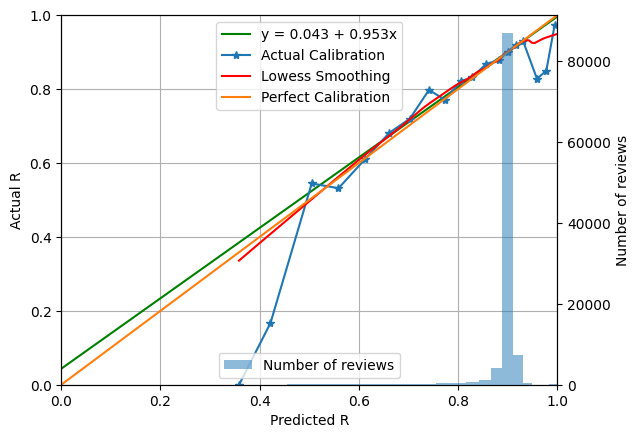

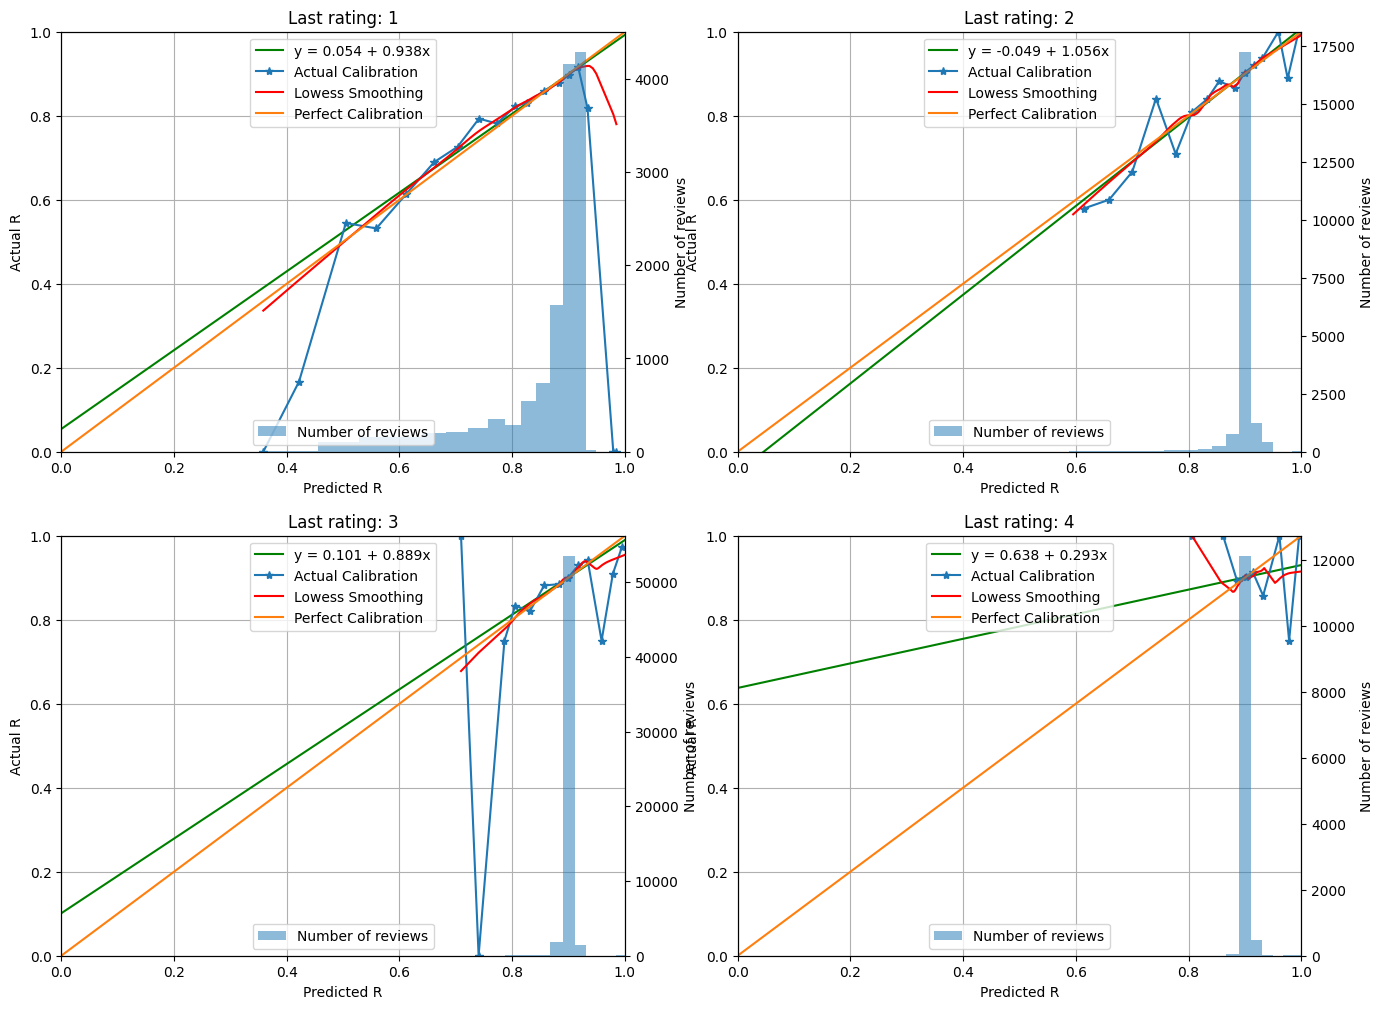

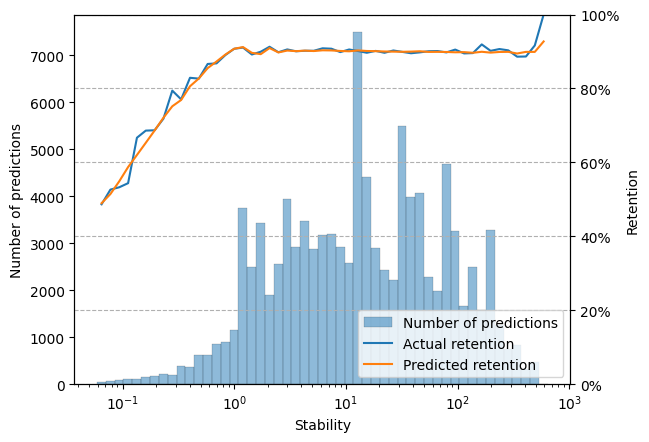

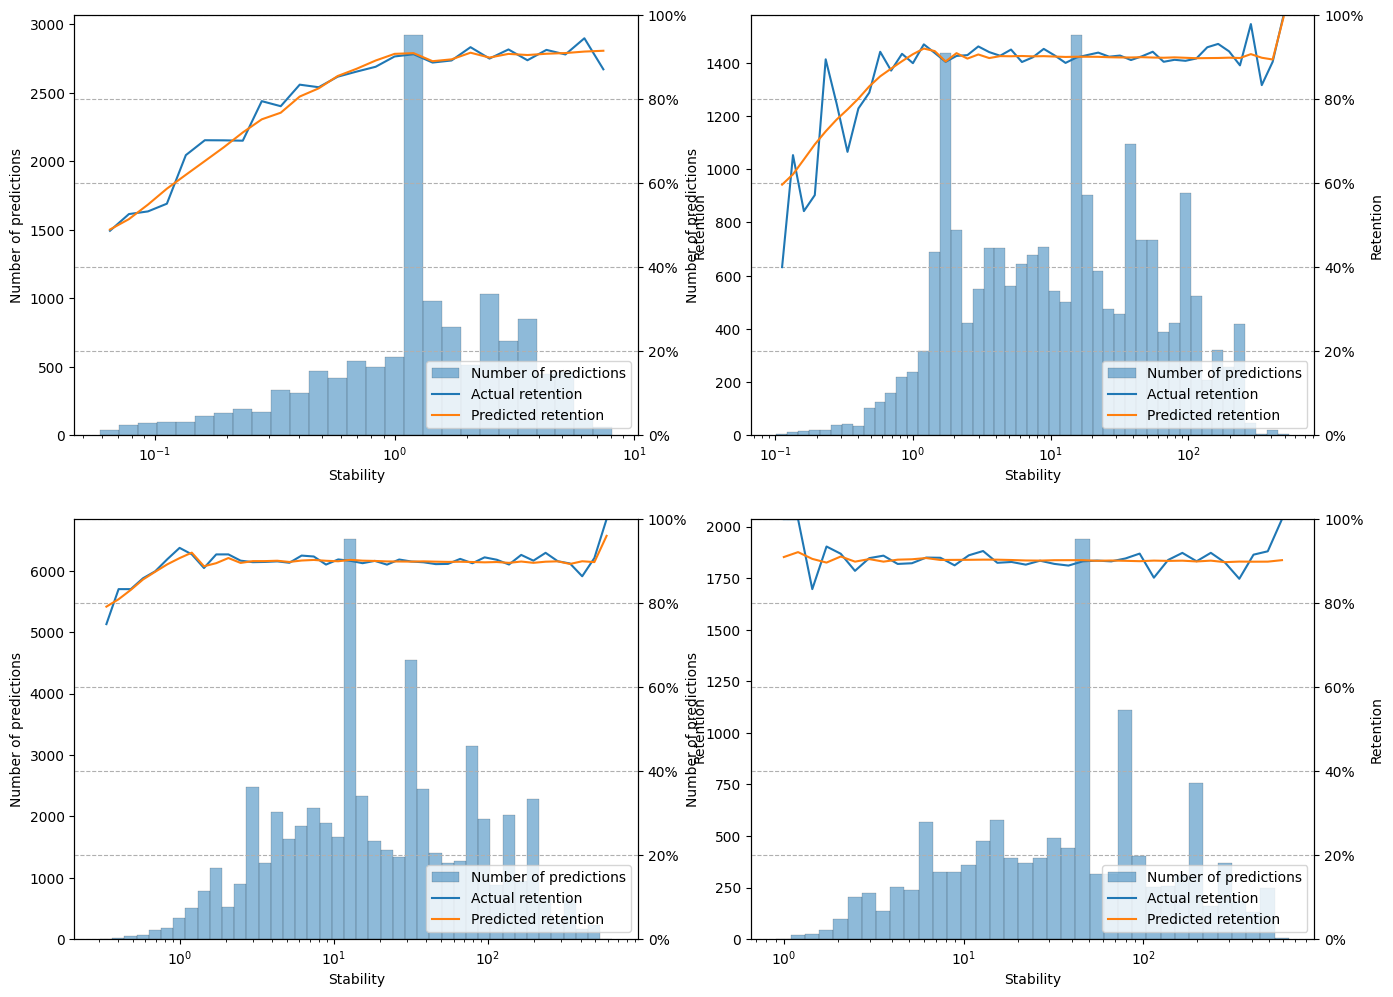

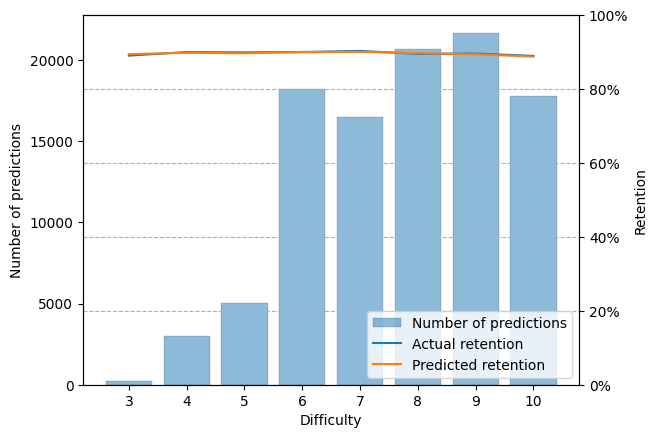

In [4]:
for learn_span in [7, 15, 30, 60, 120, 240, 480, 960]:
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    train_and_evaluate(df)